<a href="https://colab.research.google.com/github/abid1214/photo-ml/blob/main/photo_ml_class_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NV center classification and prediction


This notebook has two aims. The first is to determine a quantititive criterion for "Excellent" and "Not Excellent" comparable to Bogdanov's classification. The second is to generate a predictive classifier for time series signals based upon a limited number of data points.

First, we mount to the drive and cd to the current directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/photo_ml/src
!ls

Mounted at /content/drive
/content/drive/MyDrive/photo_ml/src
photo_ml_class_pred.ipynb  tree.dot  tree.png


In [ ]:
!pip install hurst

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import scipy as sp
import hurst as hr
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import MeanSquaredError
from keras.metrics import Precision, BinaryAccuracy, Recall, TruePositives, FalsePositives, TrueNegatives, FalseNegatives,AUC
from keras.models import model_from_json
import os
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import RBF
import h5py
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, roc_auc_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Here are some helper functions used throughout the code

In [ ]:
#padding time series with nans so all time series can fit into one matrix
def pad_time(x, max_time):
    new_x = x
    x_col = x.shape[1]
    diff = max_time - x_col
    if diff > 0:
        res = np.pad(new_x, ((0, 0), (0, diff)), 'constant', constant_values=(0, np.nan))
        return res
    return x

#remove NaNs from a signal
def clean(tmp):
    return tmp[~np.isnan(tmp)]

def standardize(tmp):
    t = tmp-np.nanmin(tmp,axis=1)[:,None]
    l=np.nanmax(t,axis=1)
    return clean(t/ l[:,None])

#computed the time-independent metrics
def ts_metrics(arr):
    if arr.ndim==1:
        return np.nanstd(arr)/np.nanmean(arr)
    data_mean = np.nanmean(arr,axis=1)
    data_std = np.nanstd(arr,axis=1)
    data_cov = data_std/data_mean
    data_vmr = (data_std**2)/data_mean
    return data_cov, data_mean, data_std, data_vmr


#exponential curve
def pl(x,a,b):
    return a*np.exp(x*b)
  
#linear curve
def line(x,a,b):
    return a*x + b
 

#sliding window for time series a with len L and stepsize S
def broadcasting_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    return a[S*np.arange(nrows)[:,None] + np.arange(L)] 

#normalize a signal (zero mean, unit variance)
def normalize(arr):
    tmp = clean(arr)
    return (tmp-np.mean(tmp))/np.std(tmp)   

def norm_by_mean(arr):
    tmp = clean(arr)
    return (tmp-np.mean(tmp))/np.mean(tmp)


#creating Sequential Keras model with one layer
def create_larger(in_dim=2,learn_rate=.0001,beta=0.9):
    model = Sequential()
    model.add(Dense(1, input_dim=in_dim, activation='sigmoid', name='dense'))
    model.compile(loss=MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate, beta_1=beta),
        metrics=[BinaryAccuracy(threshold=0.5), Precision(), Recall(),TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),AUC(name='auc'),AUC(name='prc',curve='PR')])
    return model

def get_hurst(data_mat):
    if data_mat.ndim == 1:
         h,_,_ = hr.compute_Hc(clean(data_mat),kind='change')
         return h
    hurst_array = []
    for i,tis in enumerate(data_mat): 
        h,_,_ = hr.compute_Hc(clean(tis),kind='change')
        hurst_array.append(h)
    return np.array(hurst_array)

def spectral_flatness(data_mat):
    fs=10
    if data_mat.ndim == 1:
          freq,pxx= sp.signal.welch(normalize(data_mat),fs,scaling='spectrum' )
          return sp.stats.mstats.gmean(pxx)/np.mean(pxx)

    sf = []
    for i,tis in enumerate(data_mat):
        freq,pxx= sp.signal.welch(normalize(tis),fs,scaling='spectrum' )
        sf.append(sp.stats.mstats.gmean(pxx)/np.mean(pxx))
    return np.array(sf)


def saving_model(model,json_name,h5name):
    model_json = model.to_json()
    with open(json_name, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(h5name)

def build_data_from_xlsx(input_file='../data/photoemittor_data.xlsx',num_files=4,lab=[0,1,2,3],trans=True,output_file="../data/metrics_ts_dataframe.xlsx"):
    
    if trans == True:
        data = [pd.read_excel(input_file, sheet_name=i, header=None).to_numpy().transpose() for i in range(num_files)]
    else:
        data = [pd.read_excel(input_file, sheet_name=i, header=None).to_numpy() for i in range(num_files)]
    row_sizes = [data[i].shape[0] for i in range(num_files)]
    max_time = np.max([data[i].shape[1] for i in range(num_files)])
    data_pad = [pad_time(data[i],max_time) for i in range(num_files)]
    data_mat = np.vstack(data_pad)
    tmp = [row_sizes[i]*[l] for i,l in enumerate(lab)]
    exp_labels = np.array([item for sublist in tmp for item in sublist])
    quant_ex=np.zeros_like(exp_labels)
    quant_exgo=np.zeros_like(exp_labels)
    hurst_array = get_hurst(data_mat)
    sf_array = spectral_flatness(data_mat)

    data_cov,data_mean,data_std, data_vmr = ts_metrics(data_mat)
    f_metrics = np.vstack([data_cov,data_mean,data_std,data_vmr,hurst_array,sf_array,exp_labels,quant_ex,quant_exgo]).T
    df_labels = ["cov","mean","stdev","vmr","hurst","spectral_flatness","exp_label","quant_ex","quant_exgo"]
    df_full = pd.DataFrame(f_metrics,columns=df_labels)
    df = pd.DataFrame(data_mat)
    writer = pd.ExcelWriter(output_file)
    df_full.to_excel(writer, sheet_name = "metrics")
    df.to_excel(writer, sheet_name = "ts")
    writer.save()
    writer.close()

def snip_stats(data_mat,labels,num_steps,lag):
    feature_matrix = []
    label_vector = []
    count=0
    for i,tis in enumerate(data_mat):
        sig = broadcasting_app(clean(tis),num_steps,lag)
        num_pieces = sig.shape[0]
        label_vector.extend(num_pieces*[labels[count]])
        count+=1
        for k in range(num_pieces):
              # tmp = sig[k*num_steps:(k+1)*num_steps]
            tmp = sig[k]
            feature_matrix.append([ts_metrics(tmp),get_hurst(tmp),spectral_flatness(tmp)])

    feature_matrix = np.array(feature_matrix)
    label_vector = np.array(label_vector)

    return feature_matrix,label_vector

#read in data file for full time series
def make_dict_entries(fname,num_files,lab,trans):
    i_file = "../data/{}_data.xlsx".format(fname)
    o_file = "../data/{}_dataframe.xlsx".format(fname)
    if not os.path.exists(o_file):
        print("Building the dataframe...")
        build_data_from_xlsx(input_file=i_file,num_files=num_files,lab=lab,trans=trans,output_file=o_file)

    df  = pd.read_excel(o_file,sheet_name="metrics",index_col=0)
    ts = pd.read_excel(o_file,sheet_name = "ts",index_col=0).to_numpy()
    return {fname:df}, {fname:ts}


    

Building a dictionary of dataframes including the metrics and the time series themselves

In [ ]:
file_list = ["orig_bogdanov","orig_yichen","oa_attempt_2","oleic_hexane_five_hour"]
num_files = [4,6,1,1]
label_list = [[0,1,2,3],[0,0,0,1,1,1],[0],[0]]
trans_list = [True,False,False,False]
df_dict = {}
ts_dict = {}
for i, fname in enumerate(file_list):
    df,ts = make_dict_entries(fname,num_files[i],label_list[i],trans_list[i])
    df_dict.update(df)
    ts_dict.update(ts)

# Visualizing metric performance

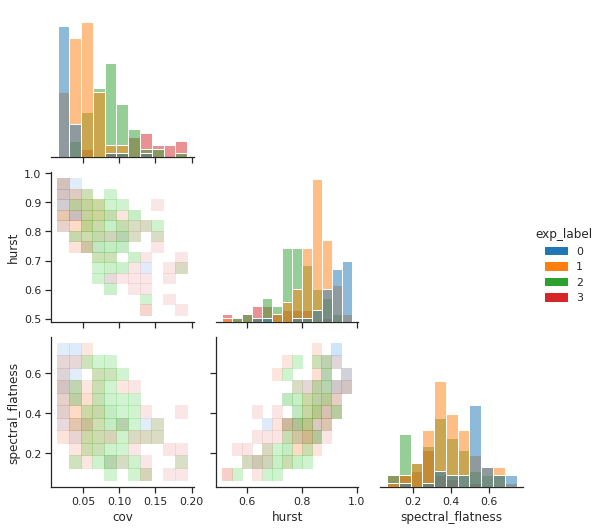

In [ ]:
class_features=["cov","hurst","spectral_flatness","exp_label"]
key = file_list[0]
df = df_dict[key][class_features]
cov_cutoff = .2
hurst_cutoff = .5
sns.set_theme(style="ticks")
mask = (df["cov"]<=cov_cutoff) & (df["hurst"] >= hurst_cutoff)
sns.pairplot(data=df.loc[mask],kind='hist',hue="exp_label",palette="tab10",corner=True,plot_kws={'alpha':0.3})

# Using a random forest regressor to find the optimal splitting for the classification

Out-of-bag score estimate: 0.923
Mean accuracy score: 0.906


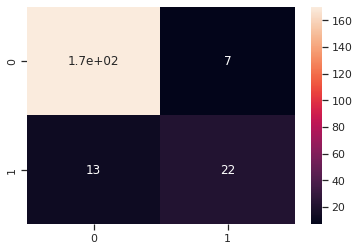

rows are the ground truth, columns are the prediction (I think)
here's the impurity score of the feature importance [0.36508763 0.3514453  0.28346707]
here's the balanced accuracy 0.7945117029862793
recall 0.6285714285714286
precision 0.7586206896551724
roc_auc 0.7945117029862793
Out-of-bag score estimate: 0.846
Mean accuracy score: 0.769


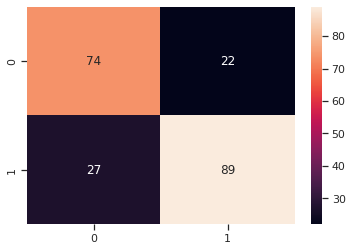

rows are the ground truth, columns are the prediction (I think)
here's the impurity score of the feature importance [0.37596237 0.43406068 0.18997695]
here's the balanced accuracy 0.7690373563218391
recall 0.7672413793103449
precision 0.8018018018018018
roc_auc 0.769037356321839


In [ ]:
key ="orig_bogdanov"
df = df_dict[key]
features = ["cov","hurst","spectral_flatness"]

#target_ex is treating the "excellent" category as the only acceptable signals
target_ex=df.exp_label.copy()
target_ex[target_ex>1] = 1
target_ex = 1-target_ex

#target_exgo treats both excellent and good as acceptable
target_exgo = df.exp_label.copy()
target_exgo[target_exgo < 2] = 0
target_exgo[target_exgo>1] = 1
target_exgo = 1-target_exgo


X_train, X_test, y_train, y_test = train_test_split(df[features], target_ex, test_size=0.8, stratify=target_ex, random_state=123456)
rf_ex = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf_ex.fit(X_train, y_train)
y_pred_ex = rf_ex.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_ex)
print(f'Out-of-bag score estimate: {rf_ex.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
conf_matrix = confusion_matrix(y_test, y_pred_ex)
cm = pd.DataFrame(conf_matrix)
sns.heatmap(cm, annot=True)
plt.show()
print("rows are the ground truth, columns are the prediction (I think)")
print("here's the impurity score of the feature importance",rf_ex.feature_importances_)
print("here's the balanced accuracy", balanced_accuracy_score(y_test,y_pred_ex))
print("recall", recall_score(y_test,y_pred_ex))
print("precision", precision_score(y_test,y_pred_ex))
print("roc_auc", roc_auc_score(y_test,y_pred_ex))

X_train, X_test, y_train, y_test = train_test_split(df[features], target_exgo, test_size=0.8, stratify=target_exgo, random_state=123456)
rf_exgo = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf_exgo.fit(X_train, y_train)
y_pred_exgo = rf_exgo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_exgo)
print(f'Out-of-bag score estimate: {rf_exgo.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
conf_matrix = confusion_matrix(y_test, y_pred_exgo)
cm = pd.DataFrame(conf_matrix)
sns.heatmap(cm, annot=True)
plt.show()
print("rows are the ground truth, columns are the prediction (I think)")
print("here's the impurity score of the feature importance",rf_exgo.feature_importances_)
print("here's the balanced accuracy", balanced_accuracy_score(y_test,y_pred_exgo))
print("recall", recall_score(y_test,y_pred_exgo))
print("precision", precision_score(y_test,y_pred_exgo))
print("roc_auc", roc_auc_score(y_test,y_pred_exgo))
# estimator = rf.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = features,
#                 class_names = [str(i) for i in np.unique(target)],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [ ]:
for key in df_dict.keys():
    df= df_dict[key]
    df.quant_ex=rf_ex.predict(df[features])
    df.quant_exgo = rf_exgo.predict(df[features])

In [23]:
key =file_list[1]
df = df_dict[key]
y_test = df.exp_label.copy()
y_test[y_test>1] = 1
y_test = 1-y_test
y_pred = rf_ex.predict(df[features])
print("here's the balanced accuracy", balanced_accuracy_score(y_test,y_pred))
print("recall", recall_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred))
print("roc_auc", roc_auc_score(y_test,y_pred))
print(y_pred)

here's the balanced accuracy 0.5172413793103449
recall 0.034482758620689655
precision 1.0
roc_auc 0.5172413793103449
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [ ]:
key =file_list[0]
mat = ts_dict[key]
df= df_dict[key]
feature_matrix,label_vector = snip_stats(mat,df.quant_exgo,100,30)
print(feature_matrix.shape)
f_metrics = np.hstack([feature_matrix,label_vector[:,np.newaxis]])
df_labels = ["cov","hurst","spectral_flatness","label"]
ten_sec_df = pd.DataFrame(f_metrics,columns=df_labels)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


(2162, 3)


In [ ]:
y_test = ten_sec_df.label
y_pred_ex = rf_exgo.predict(ten_sec_df[features])
print("here's the balanced accuracy", balanced_accuracy_score(y_test,y_pred_ex))
print("recall", recall_score(y_test,y_pred_ex))
print("precision", precision_score(y_test,y_pred_ex))

here's the balanced accuracy 0.7281505989451832
recall 0.5612691466083151
precision 0.796583850931677


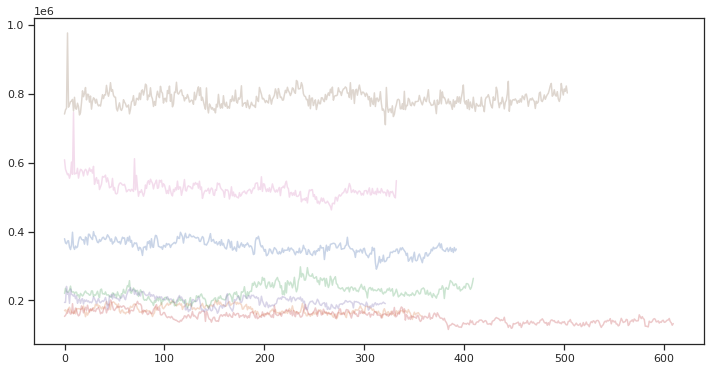

In [ ]:
key = file_list[2]
ts = ts_dict[key]
df = df_dict[key]
fig = plt.figure(figsize=(12,6))
colors=['b','orange','g','r']
for i,tis in enumerate(ts[0:7]):
    plt.plot(tis,alpha=.3)#color=colors[df.exp_label.values[i]],alpha=.3)
# plt.ylim([0,500000.00])

Given the bogdanov labeling and the metrics, let's try building a hyperplane model that performs close to the same classification

In [ ]:
#train for Bogdanov classification via hyperplane
input_json = "../models/class_model.json"
input_h5 = "../models/class_model.h5"

if os.path.exists(input_json) and os.path.exists(input_h5):
    print("already have the model available")
    json_file = open(input_json, 'r')
    class_model_json = json_file.read()
    json_file.close()
    class_model = model_from_json(class_model_json)
    class_model.load_weights(input_h5)
else:
    rel_features = ["cov","vmr","hurst_int"]
    batch_size=16
    epochs=1000
    target_labels = df_full["bog_label"].to_numpy()
    target_labels[target_labels>0] = 1  
    class_model = create_larger(in_dim = len(rel_features))
    class_model.fit(df_full[rel_features].to_numpy(),target_labels,batch_size=batch_size,epochs=epochs)
    dense=class_model.get_layer("dense")
    print(dense.get_weights())
    hyper_labels = np.rint(class_model.predict(df_full[rel_features].to_numpy()))
    saving_model(class_model,input_json,input_h5)

Given a trained classifier based upon the cov,vmr, and possible the hurst_int, let's now check how this classification performs on the new dataset Yichen classified

In [ ]:

class_model.evaluate(test_df_full[rel_features],test_df_full['bog_label'])

4/4 [==============================] - 1s 4ms/step - loss: 0.2589 - binary_accuracy: 0.7411 - precision_4: 0.7411 - recall_4: 1.0000 - tp: 83.0000 - fp: 29.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - auc: 0.5000 - prc: 0.7411


[0.25892531871795654,
 0.7410714030265808,
 0.7410714030265808,
 1.0,
 83.0,
 29.0,
 0.0,
 0.0,
 0.5,
 0.7410714030265808]

Given a revised classification based upon hyperplanes, we now want to attempt a prediction based upon only num_steps values of the time series. To give ourselves more data points, we use overlapping segments of the time series, generated by choosing a lag. The larger the lag, the fewer time series we have to work with

---



In [ ]:
feature_matrix = []
label_vector = []
count = 0
lag = 30
num_steps= 50
rel_labels=hyper_labels

for i in data_mat:
      sig = broadcasting_app(clean(i),num_steps,lag)
      num_pieces = sig.shape[0]
      label_vector.extend(num_pieces*[rel_labels[count]])
      count+=1
      for k in range(num_pieces):
            # tmp = sig[k*num_steps:(k+1)*num_steps]
          tmp = sig[k]
          feature_matrix.append(cov_vmr(tmp))

feature_matrix = np.array(feature_matrix)
label_vector = np.array(label_vector)

stat_mat = np.hstack([feature_matrix,label_vector])

In [ ]:
# %%capture dat
estimators = [('mlp', KerasClassifier(build_fn=create_larger, epochs=500, batch_size=32, verbose=1))]
pipeline = Pipeline(estimators)
from sklearn.model_selection import cross_validate
kfold = StratifiedKFold(n_splits=8, shuffle=True)
results = cross_val_score(pipeline, feature_matrix, label_vector, cv=kfold,scoring='balanced_accuracy')
print(results,results.mean(),results.std())

In [ ]:
batch_size=16
epochs=1000
input_json = "../models/pred_model.json"
input_h5 = "../models/pred_model.h5"
pred_model = create_larger(in_dim =feature_matrix.shape[1])
pred_model.fit(feature_matrix,label_vector,batch_size=batch_size,epochs=epochs)
dense=pred_model.get_layer("dense")
print(dense.get_weights())
saving_model(pred_model,input_json,input_h5)